# Diabetes dataset clustering analysis

In this notebook, I will use a clustering algorithm to detect clusters in patients based in the hospitalization outcome. The procedure will be the following

**1** Exploration Data Analysis

**2** Data celaning

**3** Clustering

**4** Conclusion

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import shap

## EDA

### Reading the dataset
In this section we are reading the dataset using Pandas, the standard procedure

In [2]:
data = pd.read_csv('./data/diabetic_data.csv')
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [75]:
print('Number of rows', data.shape[0])
print('Number of columns', data.columns.shape[0])
print(data.columns)

Number of rows 101766
Number of columns 50
Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


**Note:** There is a relevant [paper](https://downloads.hindawi.com/journals/bmri/2014/781670.pdf) where they used the dataset and released to the public. Most of their insights will be used for the analysis. This paper is going to be the benchmark to what we find here in the experiment.

### Basic exploration plots

Text(0.5, 0, "Patients' age range")

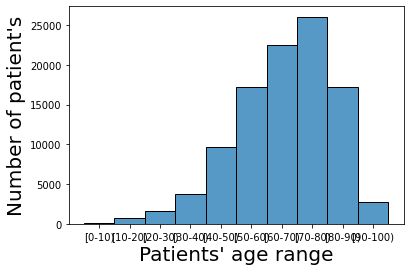

In [4]:
age_hist = sns.histplot(data=data, x="age")
age_hist.set_ylabel("Number of patient's", fontsize=20)
age_hist.set_xlabel("Patients' age range", fontsize=20)

Female             53.758623
Male               46.238429
Unknown/Invalid     0.002948
Name: gender, dtype: float64

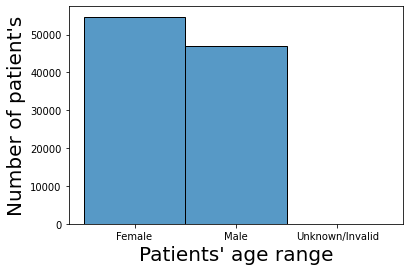

In [5]:
age_hist = sns.histplot(data=data, x="gender")
age_hist.set_ylabel("Number of patient's", fontsize=20)
age_hist.set_xlabel("Patients' age range", fontsize=20)
(data['gender'].value_counts()/data['gender'].count())*100

As expected most of the diabetic patients are after their middle age. Pediatric diabetes is a rare cases. Curiously, the data is almost even, where the number of females is higher than men with a difference of 6%. Finally, there is no need to keep the unknown/invalid gender in this test.

Text(0.5, 0, "Patients' readmission")

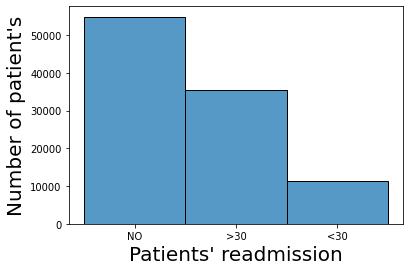

In [6]:
age_hist = sns.histplot(data=data, x="readmitted")
age_hist.set_ylabel("Number of patient's", fontsize=20)
age_hist.set_xlabel("Patients' readmission", fontsize=20)

This is interesting, patients that are readmitted before 30 days are actually a minority

In [7]:
(data['readmitted'].value_counts()/data['readmitted'].count())*100

NO     53.911916
>30    34.928169
<30    11.159916
Name: readmitted, dtype: float64

As expected 11% of the cases were readmitted before 30 days and 35% of them after. The rest didn't go to the hospital network again. There are many things to explore with just the EDA. The next thing to do is to see if there is a visual relationship between the readmission and some parameters. 

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
The `axis` variable is no longer used and will be removed. Instea

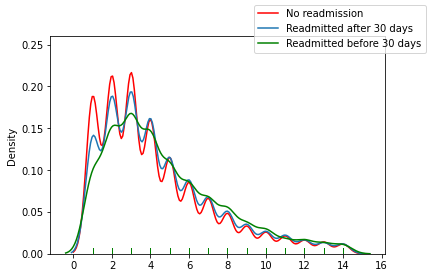

In [8]:
fig, ax = plt.subplots()
sns.distplot(data.loc[data.readmitted == 'NO']['time_in_hospital'].values, rug=True, hist=False, ax=ax, color ='r')
sns.distplot(data.loc[data.readmitted == '>30']['time_in_hospital'].values, rug=True, hist=False, ax=ax)
sns.distplot(data.loc[data.readmitted == '<30']['time_in_hospital'].values, rug=True, hist=False, ax=ax, color ='g')
fig.legend(labels=['No readmission','Readmitted after 30 days','Readmitted before 30 days'])
plt.show()

It seems that there is no apperent relationship or pattern for the patient's time at the hospital. Let's try with another variable

In [9]:
(data['weight'].value_counts()/data['weight'].count())*100

?            96.858479
[75-100)      1.312816
[50-75)       0.881434
[100-125)     0.614154
[125-150)     0.142484
[25-50)       0.095317
[0-25)        0.047167
[150-175)     0.034393
[175-200)     0.010809
>200          0.002948
Name: weight, dtype: float64

## Data cleaning

The step here is to remove the NANs, nulls and columns that have little to no contribution to the detection of patterns and predictions. In this cases the NaNs are expressed as '?'. Thus, the first thing to do is to replace the **'?'** character with NaNs to remove them

First, let's remove the patient's number, weight and payer code. Weight has too many nulls and it needs to be removed

In [10]:
data_filtered = data.copy()
data_filtered = data_filtered.drop(['encounter_id','patient_nbr','weight','payer_code'], axis=1)

In [11]:
data_filtered = data_filtered.replace('?', np.nan)
data_filtered = data_filtered.dropna()
data_filtered.shape

(49735, 46)

## Data Processing

In this process, the features are going to be generated, many of them will follow the same guidelines from the paper. One of the first things done is to only work with patients that survived. The ones that expired or were sent to hospises were excluded

In [12]:
data_filtered = data_filtered.loc[(data_filtered['discharge_disposition_id'] <= 10) | (data_filtered['discharge_disposition_id'] > 14)]
data_filtered = data_filtered.loc[(data_filtered['discharge_disposition_id'] != 18)] #excluding "NULL"
data_filtered = data_filtered.loc[(data_filtered['discharge_disposition_id'] != 19)] #excluding "Expired at home. Medicaid only, hospice."
data_filtered = data_filtered.loc[(data_filtered['discharge_disposition_id'] != 20)] #excluding "Expired in a medical facility. Medicaid only, hospice."
data_filtered = data_filtered.loc[(data_filtered['discharge_disposition_id'] != 21)] #excluding "Expired, place unknown. Medicaid only, hospice."
data_filtered = data_filtered.loc[(data_filtered['discharge_disposition_id'] != 25)] #excluding "Not Mapped"
data_filtered = data_filtered.loc[(data_filtered['discharge_disposition_id'] != 26)] #excluding "Unknown/Invalid"

Let's binarize the discharge information

In [13]:
data_filtered['discharged_home'] = data_filtered['discharge_disposition_id'] == 1

In [14]:
(data_filtered['discharged_home'].value_counts()/data_filtered['discharged_home'].count())*100

True     66.710619
False    33.289381
Name: discharged_home, dtype: float64

Let's remove patient with unknown gender

In [15]:
data_filtered = data_filtered.loc[data_filtered.gender != 'Unknown/Invalid']

Let's group the patients by type of diagnostics. In the paper there is a useful way to classify the primary diagnostics. You can see the details in the following image.

![](DiagnosticsCategories.PNG)

In [16]:
def create_type_diagnostics(row):
    if('E' in row['diag_1']):
        return 'Other'
    elif('V' in row['diag_1']):
        return 'Other'
    elif (row['diag_1'].split('.')[0] == '250'):
        return 'Diabetes'
    elif(int(row['diag_1'])>=390 and int(row['diag_1'])<=459) or row['diag_1']==785:
        return 'Circulatory'
    elif((int(row['diag_1'])>=460 and int(row['diag_1'])<=519) or row['diag_1']==786):
        return 'Respiratory'
    elif(int(row['diag_1'])>=520 and int(row['diag_1'])<=579) or row['diag_1']==787:
        return 'Digestive'
    elif(int(row['diag_1'])>=800 and int(row['diag_1'])<=999):
        return 'Injury'
    elif(int(row['diag_1'])>=710 and int(row['diag_1'])<=739):
        return 'Musculoskeletal'
    elif(int(row['diag_1'])>=580 and int(row['diag_1'])<=629) or row['diag_1']==788:
        return 'Genitourinary'
    elif(int(row['diag_1'])>=140 and int(row['diag_1'])<=239):
        return 'Neoplasm'
    else:
        return 'Other'
    pass

In [17]:
data_filtered['TypeCondition'] = data_filtered.apply(create_type_diagnostics, axis=1)

Let's compare the type of condition percentages with the one in the paper:

In [18]:
(data_filtered['TypeCondition'].value_counts()/data_filtered['TypeCondition'].count())*100

Circulatory        30.776265
Other              22.658443
Respiratory         9.011059
Digestive           8.662271
Diabetes            8.249681
Injury              6.729051
Musculoskeletal     5.971927
Genitourinary       4.536368
Neoplasm            3.404934
Name: TypeCondition, dtype: float64

We can see that is quite similar. There is no abnormal changes compared to the paper proportions. This could be caused by the data we filtered in the process. Because, the rows that have the character '?' were removed, this may affected the proportion but not significatively so we can proceed with the experiment

Since this is a skill assessment, and we are tasked to find some patterns and interesing things let's keep it simple. Finally, the medicines are going to be binarized and the final variables are going to be selected

In [19]:
medicine_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

In [20]:
for medicine in medicine_cols:
    data_filtered[medicine+'_bin'] = data_filtered[medicine] != 'No'

In [21]:
data_filtered['any_medicine'] = 0
for medicine in medicine_cols:
    data_filtered['any_medicine'] = data_filtered['any_medicine'] + data_filtered[medicine+'_bin']

In [22]:
data_filtered['change_bin'] = data_filtered.change == 'Ch'

In [23]:
data_filtered['diabetesMed_bin'] = data_filtered.diabetesMed == 'Yes'

In [24]:
data_filtered['A1Cresult_bin'] = data_filtered['A1Cresult'] != 'None'
data_filtered['num_procedures_bin'] = data_filtered['num_procedures'] != 0

Now that we have all that we need, let's extract the most useful columns for the model

In [25]:
data_filtered.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'discharged_home', 'TypeCondition', 'metformin_bin', 'repaglinide_bin',
       'nateglinide_bin', 'chlorpropamide_bin', 'glimepiride_bin',
       '

In [26]:
diabetic_data = data_filtered.copy()
diabetic_data = diabetic_data[['discharged_home','race','gender','age','time_in_hospital','change_bin','diabetesMed_bin','TypeCondition','A1Cresult_bin','readmitted']]

In [27]:
diabetic_data.head()

,discharged_home,race,gender,age,time_in_hospital,change_bin,diabetesMed_bin,TypeCondition,A1Cresult_bin,readmitted
9,False,Caucasian,Female,[90-100),12,True,True,Circulatory,False,NO
12,False,Caucasian,Female,[40-50),7,True,True,Circulatory,False,<30
13,False,Caucasian,Male,[80-90),10,False,True,Circulatory,False,NO
17,True,Caucasian,Female,[50-60),3,False,True,Other,False,NO
26,False,Caucasian,Male,[80-90),6,True,True,Circulatory,True,NO


In [28]:
diabetic_data['race'] = diabetic_data['race'].astype('category')
diabetic_data['gender'] = diabetic_data['gender'].astype('category')
diabetic_data['TypeCondition'] = diabetic_data['TypeCondition'].astype('category')

Since python clustering depends on the data to be numbers. We will transform the data into numbers

### Race
1- Caucasian

2- AfricanAmerican

3- Hispanic

4- Asian

5- Other

In [29]:
race_dict = {
    'Caucasian':1,
    'AfricanAmerican':2,
    'Hispanic':3,
    'Asian':4,
    'Other':5
}
diabetic_data['num_race'] = diabetic_data['race'].map(race_dict)
diabetic_data['num_race'].drop_duplicates()

9      1
98     5
523    3
804    4
897    2
Name: num_race, dtype: category
Categories (5, int64): [2, 4, 1, 3, 5]

### Gender

1- Female

2- Male

In [30]:
gender_dict = {
    'Female':1,
    'Male':2
}
diabetic_data['num_gender'] = diabetic_data['gender'].map(gender_dict)
diabetic_data['num_gender'].drop_duplicates()

9     1
13    2
Name: num_gender, dtype: category
Categories (2, int64): [1, 2]

### Type of condition
1- Circulatory

2- Diabetes

3- Respiratory

4- Digestive

5- Injury

6- Musculoskeletal

7- Genitourinary

8- Neoplasm

9- Other

In [31]:
condition_dict = {
    'Circulatory':1,
    'Diabetes':2,
    'Respiratory':3,
    'Digestive':4,
    'Injury':5,
    'Musculoskeletal':6,
    'Genitourinary':7,
    'Neoplasm':8,
    'Other':9
}
diabetic_data['num_TypeCondition'] = diabetic_data['TypeCondition'].map(condition_dict)
diabetic_data['num_TypeCondition'].drop_duplicates()

9      1
17     9
27     5
73     8
77     6
98     7
115    4
152    2
181    3
Name: num_TypeCondition, dtype: category
Categories (9, int64): [1, 2, 4, 7, ..., 6, 8, 9, 3]

### Age
1- [0-10)

2- [10-20)

3- [20-30)

4- [30-40)

5- [40-50)

6- [50-60)

7- [60-70)

8- [70-80)

9- [80-90)

10- [90-100)

In [32]:
age_dict = {
    '[0-10)':1,
    '[10-20)':2,
    '[20-30)':3,
    '[30-40)':4,
    '[40-50)':5,
    '[50-60)':6,
    '[60-70)':7,
    '[70-80)':8,
    '[80-90)':9,
    '[90-100)':10
}
diabetic_data['num_age'] = diabetic_data['age'].map(age_dict)
diabetic_data['num_age'].drop_duplicates()

9       10
12       5
13       9
17       6
32       8
35       7
115      4
1037     3
1046     2
1140     1
Name: num_age, dtype: int64

In [33]:
diabetic_data.readmitted.drop_duplicates()

9      NO
12    <30
27    >30
Name: readmitted, dtype: object

In [34]:
readmitted_dict = {
    'NO':0,
    '<30':1,
    '>30':2
}
diabetic_data['num_readmitted'] = diabetic_data['readmitted'].map(readmitted_dict)
diabetic_data['num_readmitted'].drop_duplicates()

9     0
12    1
27    2
Name: num_readmitted, dtype: int64

In [35]:
diabetic_data.to_csv('./data/diabetic_data_processed.csv')

## Clustering

Let's use the PCA dimensionality reduction in order to visualize the clusters in 2D and 3D if there is more complications

In [36]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [37]:
X_cols = ['discharged_home','num_race','num_gender','num_age','time_in_hospital','change_bin','diabetesMed_bin','num_TypeCondition','A1Cresult_bin']
y_cols = 'readmitted'
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(diabetic_data[X_cols], diabetic_data.num_readmitted.values).transform(diabetic_data[X_cols])
y_diabetic = diabetic_data.num_readmitted.values

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.


In [ ]:
plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
for color, i, target_name in zip(colors, [0,1,2], target_names_diabetic):
    plt.scatter(X_r2[y_diabetic == i, 0], X_r2[y_diabetic == i, 1], alpha=.2, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of diabetic dataset')

plt.show()

It looks like there is no visible pattern. Let's try to create a model for prediction and use SHAP for insights and useful things. Because for different predictions, different factors have a key role, we are going togo into the scenario 'us' vs 'them'. Thus, we're going to generate different models for all the categories. First let's generate the binarized categories

In [38]:
diabetic_data['NoReadmission'] = diabetic_data.readmitted == 'NO'
diabetic_data['ReturnedBefore30'] = diabetic_data.readmitted == '<30'
diabetic_data['ReturnedAfter30'] = diabetic_data.readmitted == '>30'

In [39]:
diabetic_data.to_csv('./data/diabetic_data_processed_bin.csv')

In [40]:
def evaluate_model(classifier, X, y, train_size=0.8, total_samples=100, smote=False, best_model=False):
    """
    if smote is True:
        oversample = SMOTE()
        X, y = oversample.fit_resample(X, y)
    """
    oversample = SMOTE()
    #scaler.fit(X)
    X_scaled = X#scaler.transform(X)
    auc_vals = np.array([])
    acc_vals = np.array([])
    specificity_vals = np.array([])
    sensitivity_vals = np.array([])
    ppv_vals = np.array([])
    model_list = []
    proba_vals = []
    test_vals = []
    fpr_vals = []
    tpr_vals = []
    for i in range(1,total_samples):
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=train_size)
        if smote is True:
            X_train, y_train = oversample.fit_resample(X_train, y_train)
        clf = classifier
        model = clf.fit(X_train,y_train)
        model_list.append(model)
        y_hat = model.predict_proba(X_test)
        # print(y_hat.flatten())
        # print(y_test)
        # print(y_hat.shape)
        # print(y_test.shape)
        proba_vals.append(y_hat[:,1])
        test_vals.append(y_test)
        if np.sum(np.round(y_hat[:,1])) == 0:
            continue
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_hat[:,1])
        tn, fp, fn, tp = confusion_matrix(y_test,np.round(y_hat[:,1])).ravel()
        specificity = tn / (tn+fp)
        sensitivity = tp / (tp+fn)
        ppv = tp/(tp+fp)
        auc_vals = np.append(metrics.auc(fpr, tpr),auc_vals)
        acc_vals = np.append(accuracy_score(y_test, np.round(y_hat[:,1])),acc_vals)
        specificity_vals = np.append(specificity,specificity_vals)
        sensitivity_vals = np.append(sensitivity,sensitivity_vals)
        ppv_vals = np.append(ppv,ppv_vals)
        fpr_vals.append(fpr)
        tpr_vals.append(tpr)
        pass
    print('AUC: {:.3f} +- {:.3f}'.format(np.mean(auc_vals), np.std(auc_vals)))
    print('Sensitivity: {:.3f} +- {:.3f}'.format(np.mean(sensitivity_vals), np.std(sensitivity_vals)))
    print('Specificity: {:.3f} +- {:.3f}'.format(np.mean(specificity_vals), np.std(specificity_vals)))
    print('Positive Predictive Values: {:.3f} +- {:.3f}'.format(np.mean(ppv_vals), np.std(ppv_vals)))
    print('Accuracy: {:.3f} +- {:.3f}'.format(np.mean(acc_vals), np.std(acc_vals)))
    if best_model is True:
        best_vals = ppv_vals*1.25 + sensitivity_vals
        max_ppv_index = np.argmax(best_vals)
        print(max_ppv_index)
        print('The highest ppv model has the following:')
        print('AUC: {:.3f}'.format(auc_vals[max_ppv_index]))
        print('Sensitivity: {:.3f}'.format(sensitivity_vals[max_ppv_index]))
        print('Specificity: {:.3f}'.format(specificity_vals[max_ppv_index]))
        print('Positive Predictive Values: {:.3f}'.format(ppv_vals[max_ppv_index]))
        print('Accuracy: {:.3f}'.format(acc_vals[max_ppv_index]))
        
        return model_list[max_ppv_index],proba_vals,test_vals,fpr_vals[max_ppv_index],tpr_vals[max_ppv_index]
    pass

In [41]:
diabetic_data.columns

Index(['discharged_home', 'race', 'gender', 'age', 'time_in_hospital',
       'change_bin', 'diabetesMed_bin', 'TypeCondition', 'A1Cresult_bin',
       'readmitted', 'num_race', 'num_gender', 'num_TypeCondition', 'num_age',
       'num_readmitted', 'NoReadmission', 'ReturnedBefore30',
       'ReturnedAfter30'],
      dtype='object')

In [42]:
diabetic_unfold = diabetic_data.copy()
diabetic_unfold['race_caucasian'] = diabetic_data.race == 'Caucasian'
diabetic_unfold['race_other'] = diabetic_data.race == 'Other'
diabetic_unfold['race_hispanic'] = diabetic_data.race == 'Hispanic'
diabetic_unfold['race_asian'] = diabetic_data.race == 'Asian'
diabetic_unfold['race_african'] = diabetic_data.race == 'AfricanAmerican'
diabetic_unfold['gender_female'] = diabetic_data.gender == 'Female'
diabetic_unfold['gender_male'] = diabetic_data.gender == 'Male'
diabetic_unfold['age_0_10'] = diabetic_data.age == '[0-10)'
diabetic_unfold['age_10_20'] = diabetic_data.age == '[10-20)'
diabetic_unfold['age_20_30'] = diabetic_data.age == '[20-30)'
diabetic_unfold['age_30_40'] = diabetic_data.age == '[30-40)'
diabetic_unfold['age_40_50'] = diabetic_data.age == '[40-50)'
diabetic_unfold['age_50_60'] = diabetic_data.age == '[50-60)'
diabetic_unfold['age_60_70'] = diabetic_data.age == '[60-70)'
diabetic_unfold['age_70_80'] = diabetic_data.age == '[70-80)'
diabetic_unfold['age_80_90'] = diabetic_data.age == '[80-90)'
diabetic_unfold['age_90_100'] = diabetic_data.age == '[90-100)'
diabetic_unfold['condition_circulatory'] = diabetic_data.TypeCondition == 'Circulatory'
diabetic_unfold['condition_other'] = diabetic_data.TypeCondition == 'Other'
diabetic_unfold['condition_injury'] = diabetic_data.TypeCondition == 'Injury'
diabetic_unfold['condition_neoplasm'] = diabetic_data.TypeCondition == 'Neoplasm'
diabetic_unfold['condition_muscleskeletal'] = diabetic_data.TypeCondition == 'Musculoskeletal'
diabetic_unfold['condition_genitourinary'] = diabetic_data.TypeCondition == 'Genitourinary'
diabetic_unfold['condition_digestive'] = diabetic_data.TypeCondition == 'Digestive'
diabetic_unfold['condition_diabetes'] = diabetic_data.TypeCondition == 'Diabetes'
diabetic_unfold['condition_respiratory'] = diabetic_data.TypeCondition == 'Respiratory'

In [50]:
# X_cols = ['discharged_home','race_caucasian','race_other','race_hispanic','race_asian','race_african','gender_female','gender_male',
# 'age_0_10','age_10_20','age_20_30','age_30_40','age_40_50','age_50_60','age_60_70','age_70_80','age_80_90','age_90_100','condition_circulatory',
# 'condition_other','condition_injury','condition_neoplasm','condition_muscleskeletal','condition_genitourinary','condition_digestive','condition_diabetes',
# 'condition_respiratory','change_bin', 'diabetesMed_bin','A1Cresult_bin']

In [69]:
X_cols = ['discharged_home','race_caucasian','race_other','race_hispanic','race_asian','race_african','gender_female','gender_male',
'age_0_10','age_10_20','age_20_30','age_30_40','age_40_50','age_50_60','age_60_70','age_70_80','age_80_90','age_90_100','condition_circulatory',
'condition_other','condition_injury','condition_neoplasm','condition_muscleskeletal','condition_genitourinary','condition_digestive','condition_diabetes',
'condition_respiratory','change_bin', 'diabetesMed_bin','A1Cresult_bin']

In [70]:
X, y = diabetic_unfold[X_cols].values, diabetic_unfold['NoReadmission'].values
#scaler_test = StandardScaler(with_mean=False, with_std=False)
clf_selected = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features=0.1,min_samples_leaf=0.01,
                            min_samples_split=0.01,n_estimators=400,oob_score=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
model = clf_selected.fit(X_train,y_train)
#clf_cardiac, proba_cardiac, y_test_cardiac, fpr_car, tpr_car = evaluate_model(clf_selected,X, y, total_samples=2, train_size=0.7, smote=True,best_model=True)

In [71]:
y_hat = model.predict_proba(X_test)

In [72]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_hat[:,1])
metrics.auc(fpr, tpr)

0.5690131215004093

In [45]:
X, y = diabetic_unfold[X_cols].values, diabetic_unfold['ReturnedBefore30'].values
#scaler_test = StandardScaler(with_mean=False, with_std=False)
clf_selected = RandomForestClassifier(bootstrap=True,  criterion="entropy",max_features=0.1,min_samples_leaf=0.01,
                            min_samples_split= 0.01,n_estimators=50,oob_score=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
clf_cardiac, proba_cardiac, y_test_cardiac, fpr_car, tpr_car = evaluate_model(clf_selected,X, y, total_samples=1, train_size=0.7, smote=False,best_model=True)

AUC: nan +- nan
Sensitivity: nan +- nan
Specificity: nan +- nan
Positive Predictive Values: nan +- nan
Accuracy: nan +- nan


Mean of empty slice.
invalid value encountered in double_scalars
Degrees of freedom <= 0 for slice
invalid value encountered in true_divide
invalid value encountered in double_scalars


ValueError: attempt to get argmax of an empty sequence

In [46]:
X, y = diabetic_unfold[X_cols].values, diabetic_unfold['ReturnedAfter30'].values
#scaler_test = StandardScaler(with_mean=False, with_std=False)
clf_selected = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features=0.1,min_samples_leaf=0.01,
                            min_samples_split=0.01,n_estimators=400,oob_score=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
clf_cardiac, proba_cardiac, y_test_cardiac, fpr_car, tpr_car = evaluate_model(clf_selected,X, y, total_samples=1, train_size=0.7, smote=True,best_model=True)

AUC: nan +- nan
Sensitivity: nan +- nan
Specificity: nan +- nan
Positive Predictive Values: nan +- nan
Accuracy: nan +- nan


Mean of empty slice.
invalid value encountered in double_scalars
Degrees of freedom <= 0 for slice
invalid value encountered in true_divide
invalid value encountered in double_scalars


ValueError: attempt to get argmax of an empty sequence

In [ ]:
diabetic_data.TypeCondition.drop_duplicates()

Now, let's evaluate for each model

## No Readmission

In [ ]:
X, y = diabetic_data[X_cols].values, diabetic_data['NoReadmission'].values
#scaler_test = StandardScaler(with_mean=False, with_std=False)
clf_selected = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features=0.1,min_samples_leaf=0.01,
                            min_samples_split=0.01,n_estimators=400,oob_score=True)
clf_selected = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features=0.1,min_samples_leaf=0.01,
                            min_samples_split=0.01,n_estimators=400,oob_score=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
clf_cardiac, proba_cardiac, y_test_cardiac, fpr_car, tpr_car = evaluate_model(clf_selected,X, y, total_samples=15, train_size=0.7, smote=False,best_model=True)
#clf = clf_selected
#model = clf.fit(X_train,y_train)
#y_hat = model.predict_proba(X_test)
#clf_nr, proba_nr, y_test_nr, fpr_nr, tpr_nr = evaluate_model(clf_selected,X, y, total_samples=200, train_size=0.7, smote=False,best_model=True)

In [ ]:
diabetic_data.readmitted

In [ ]:
diabetic_data.NoReadmission

In [ ]:
X, y = diabetic_data[X_cols].values, diabetic_data['readmitted'].values
#scaler_test = StandardScaler(with_mean=False, with_std=False)
clf_selected = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features=0.1,min_samples_leaf=0.01,
                            min_samples_split=0.01,n_estimators=400,oob_score=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
#clf_cardiac, proba_cardiac, y_test_cardiac, fpr_car, tpr_car = evaluate_model(clf_selected,X, y, total_samples=200, train_size=0.7, smote=True,best_model=True)
clf = clf_selected
model = clf.fit(X_train,y_train)
y_hat = model.predict_proba(X_test)

In [ ]:
y_hat

In [ ]:
y_test

In [ ]:
X_cols = ['discharged_home','num_race','num_gender','num_age','time_in_hospital','change_bin','diabetesMed_bin','num_TypeCondition','A1Cresult_bin']
y_cols = 'readmitted'
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(diabetic_data[X_cols], diabetic_data.num_readmitted.values).transform(diabetic_data[X_cols])
pca = PCA(n_components=2)
X_r = pca.fit(diabetic_data[X_cols]).transform(diabetic_data[X_cols])

In [ ]:
plt.figure()

for color, i, target_name in zip(colors, [0, 1, 2], target_names_diabetic):
    plt.scatter(X_r[y_diabetic == i, 0], X_r[y_diabetic == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()

In [ ]:
diabetic_data.num_readmitted

In [ ]:
X = iris.data
y = iris.target
target_names = iris.target_names

In [ ]:
X.shape
y.shape

In [ ]:
diabetic_data[X_cols].shape
y_diabetic = diabetic_data.num_readmitted.values

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(diabetic_data[X_cols], diabetic_data.num_readmitted.values).transform(diabetic_data[X_cols])

In [ ]:
X_r2.shape

In [ ]:
target_names_diabetic = np.array(['No','<30','>30'])

In [ ]:
X_r2[y_diabetic == 0, 0]

In [ ]:
plt.figure()
for color, i, target_name in zip(colors, [0,1,2], target_names_diabetic):
    plt.scatter(X_r2[y == i, 0], X_r2[y_diabetic == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()

In [ ]:
colors

In [ ]:
plt.figure()
for color, i, target_name in zip(colors, [0,1,2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()

In [ ]:
X_cols = ['discharged_home','num_race','num_gender','num_age','time_in_hospital','change_bin','diabetesMed_bin','num_TypeCondition','A1Cresult_bin']
y_cols = 'readmitted'
X_pca = diabetic_data[X_cols].values
y = diabetic_data.readmitted
pca = PCA(n_components=2)
X_r_pca = pca.fit(X_pca).transform(X_pca)

In [ ]:

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], y):
    plt.scatter(X_r_pca[y == i, 0], X_r_pca[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()

In [ ]:
X_r.shape

In [ ]:
X_r_pca[:,0]

In [ ]:
plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2
target_names = diabetic_data.readmitted.drop_duplicates().values

In [ ]:
X_r

In [ ]:
plt.scatter(X_r[:, 0], X_r[:, 1])

In [ ]:
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

In [ ]:
(data_filtered['medical_specialty'].value_counts()/data_filtered['medical_specialty'].count())*100

In [ ]:
(data_filtered['admission_source_id'].value_counts()/data_filtered['admission_source_id'].count())*100

In [ ]:
data_filtered.medical_specialty.drop_duplicates()

In [ ]:
data_filtered['discharge_disposition_id'].drop_duplicates()

In [ ]:
target_names

In [ ]:
plt.scatter(X_r[y == 0, 0],X_r[y == 0, 1])

In [ ]:
###Experiment zone
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()

In [ ]:
len(medicine_cols)

In [ ]:
data_filtered.miglitol_bin.sum()

In [ ]:
data_filtered.columns

In [ ]:
data_filtered.loc[data_filtered.diag_1 == '?'].diag_1

In [ ]:
(data_filtered['num_medications'].value_counts()/data_filtered['num_medications'].count())*100

In [ ]:
(data_filtered['any_medicine'].value_counts()/data_filtered['any_medicine'].count())*100

In [ ]:
data_filtered=

In [ ]:
data_filtered.diag_1

## Clustering

## Model creation

In [ ]:
print(data.time_in_hospital.drop_duplicates())
print(data.max_glu_serum.drop_duplicates())
#ax = sns.distplot(data.age)

In [ ]:
data['change'].drop_duplicates()

In [ ]:
data.groupby('weight').count()

In [ ]:
data.shape[0]
data.number_emergency

In [ ]:
data.race.drop_duplicates()